# Amazon SageMaker MLOps: from idea to production in six steps

This sequence of six notebooks takes you from developing your ML idea in a simple notebook to a production solution with automated model building and CI/CD deployment pipelines, and model monitoring.

Follow these steps one by one:
1. Experiment in a notebook
2. Move to SageMaker SDK for data processing and training
3. Add an ML pipeline, a model registry, a feature store
4. Add a model building CI/CD pipeline
5. Add a model deployment CI/CD pipeline
6. Add data quality monitoring

![](img/six-steps.png)

There are also additional hands-on examples of other SageMaker features and ML topics, like [A/B testing](https://docs.aws.amazon.com/sagemaker/latest/dg/model-validation.html), custom [processing](https://docs.aws.amazon.com/sagemaker/latest/dg/build-your-own-processing-container.html), [training](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html) and [inference](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-inference-main.html) containers, [debugging and profiling](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html), [security](https://docs.aws.amazon.com/sagemaker/latest/dg/security.html), [multi-model](https://docs.aws.amazon.com/sagemaker/latest/dg/multi-model-endpoints.html) and [multi-container](https://docs.aws.amazon.com/sagemaker/latest/dg/multi-container-endpoints.html) endpoints, and [serial inference pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/inference-pipelines.html). Explore the notebooks in the folder `additional-topics` to test out these features.

To run this notebook and all notebooks in the workshop please use the `Data Science 3.0` image in Studio:

![](img/studio-notebook-kernel.png)

## Star GitHub repository

In [3]:
%%html

<a class="github-button" href="https://github.com/hieuphung97/amazon-sagemaker-blip-vqa-finetune-example" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-star" data-size="large" data-show-count="true" aria-label="Star this repo on GitHub">Star</a>
<script async defer src="https://buttons.github.io/buttons.js"></script>

### Click this button ^^^ above ^^^

## Setup
Get the latest version of SageMaker Python SDK.

<div class="alert alert-info"> 💡 The workshop and all notebooks were tested on the SageMaker Python SDK (the package sagemaker) version 2.208.0. The notebooks don't pin the version of the sagemaker. If you encounter any incompatibility issues, you can install the specific version of the sagemaker by running the pip command: <code>%pip install sagemaker=2.208.0</code>
</div>

In [4]:
# Uncomment if you have any compatibility issues and would like to use the specific version of the sagemaker library
# %pip install sagemaker==2.208.0
%pip install --upgrade pip sagemaker

  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached sagemaker-2.218.1-py3-none-any.whl.metadata (14 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)
Using cached sagemaker-2.218.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.214.3
    Uninstalling sagemaker-2.214.3:
      Successfully uninstalled sagemaker-2.214.3
Note: you may need to restart the kernel to use updated packages.


### Import packages

In [5]:
import time
import os
import json
import boto3
import numpy as np  
import pandas as pd 
import sagemaker

sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


'2.218.1'

### Set constants

In [6]:
# Get some variables you need to interact with SageMaker service
boto_session = boto3.Session()
region = boto_session.region_name
bucket_name = sagemaker.Session().default_bucket()
bucket_prefix = "blip-vqa"  
sm_session = sagemaker.Session()
sm_client = boto_session.client("sagemaker")
sm_role = sagemaker.get_execution_role()
# dataset_file_local_path = "data/bank-additional/bank-additional-full.csv"

initialized = True

print(sm_role)

arn:aws:iam::250506505253:role/service-role/AmazonSageMaker-ExecutionRole-20240507T111746


In [7]:
# Store some variables to keep the value between the notebooks
%store bucket_name
%store bucket_prefix
%store sm_role
%store region
%store initialized
# %store dataset_file_local_path

Stored 'bucket_name' (str)
Stored 'bucket_prefix' (str)
Stored 'sm_role' (str)
Stored 'region' (str)
Stored 'initialized' (bool)


### Get domain id
You need this value `domain_id` in many SageMaker Python SDK and boto3 SageMaker API calls. The notebook metadata file contains `domain_id` value. The following code demonstrates how to access the notebook metadata file and get the `domain_id`.

In [8]:
NOTEBOOK_METADATA_FILE = "/opt/ml/metadata/resource-metadata.json"
domain_id = None

if os.path.exists(NOTEBOOK_METADATA_FILE):
    with open(NOTEBOOK_METADATA_FILE, "rb") as f:
        metadata = json.loads(f.read())
        domain_id = metadata.get('DomainId')
        user_profile_name = metadata.get('UserProfileName')
        print(f"SageMaker domain id: {domain_id}")

%store domain_id
%store user_profile_name

SageMaker domain id: d-rvigbtfoquob
Stored 'domain_id' (str)
Stored 'user_profile_name' (NoneType)


## Data

This example uses the VQA data collected from [this GitHub repo](https://github.com/dino-chiio/blip-vqa-finetune).

Dataset download link: https://drive.google.com/file/d/1tt6qJbOgevyPpfkylXpKYy-KaT4_aCYZ/view?usp=sharing

### Unzip the dataset

In [9]:
import zipfile

data_zip_path = "../IconDomainVQAData.zip"

with zipfile.ZipFile(data_zip_path, "r") as z:
    print("Unzipping VQA data...")
    z.extractall("data")

print("Done")

Unzipping VQA data...
Done


### See the data

In [21]:

from pathlib import Path

from PIL import Image

data_root = Path('data/IconDomainVQAData/')
train_sample = data_root / 'train_fill_in_blank/train_fill_in_blank/10002'
test_sample = data_root / 'test_data/test_data/1311'

Show a train sample

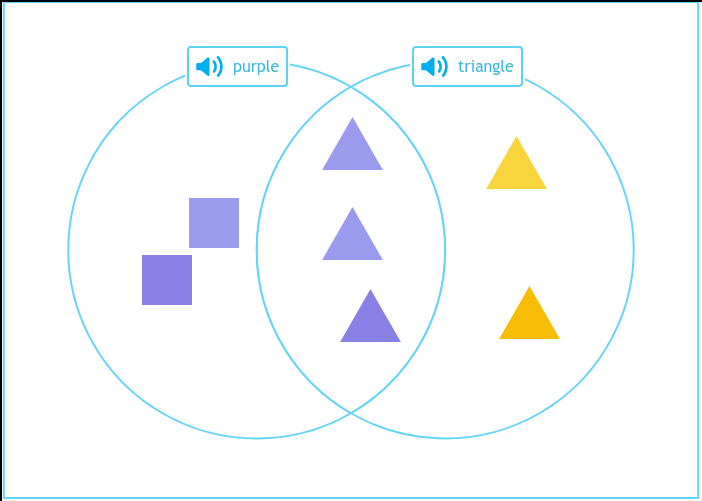

In [18]:
Image.open(train_sample / 'image.png')

In [19]:
with open(train_sample / 'data.json') as fp:
    print(json.load(fp))

{'question': 'How many shapes are purple?', 'answer': '5', 'ques_type': 'fill_in_blank', 'grade': 'grade2', 'label': 'R15'}


Show a test sample

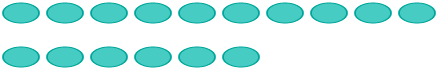

In [15]:
Image.open(test_sample / 'image.png')

In [17]:
with open(test_sample / 'data.json') as fp:
    print(json.load(fp))

{'question': 'How many ovals are there?', 'id': '1311'}


### Upload data to S3

In [23]:
input_s3_url = sagemaker.Session().upload_data(
    path=data_zip_path,
    bucket=bucket_name,
    key_prefix=f"{bucket_prefix}/input"
)
print(f"Upload the dataset to {input_s3_url}")

%store input_s3_url

Upload the dataset to s3://sagemaker-ap-northeast-1-250506505253/blip-vqa/input/IconDomainVQAData.zip
Stored 'input_s3_url' (str)


## Restart kernel

In [24]:
# Restart kernel to get the packages
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Further workshop flow
You can continue the workshop by going through each of the following notebooks in the direct order, e.g. 1-2-3-4....

If you're interested in a particular topic, you can execute some notebooks standalone, as shown in the following flow diagram:

![](img/workshop-flow.png)

Start with the step 1 [Idea Development](01-idea-development.ipynb) or step 3 [SageMaker Pipelines](03-sagemaker-pipeline.ipynb).

## Additional resources

### Documentation
- [Use Amazon SageMaker Built-in Algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html)

### Hands-on examples
- [Get started with Amazon SageMaker](https://aws.amazon.com/sagemaker/getting-started/)


### Workshops
- [Amazon SageMaker 101 Workshop](https://catalog.us-east-1.prod.workshops.aws/workshops/0c6b8a23-b837-4e0f-b2e2-4a3ffd7d645b/en-US)